In [42]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

# Configuration
DATA_PATH = r'C:\Users\RADHA KRISHNA\Downloads\data analysis project\data\blinkit_cleaned_data.csv'

# 1. Advanced Data Preparation
print("Loading and transforming data...")
df = pd.read_csv(DATA_PATH, parse_dates=['order_date'])
daily = df.resample('D', on='order_date').agg({
    'order_id': 'count',
    'order_total': 'mean',
    'quantity': 'sum'
}).rename(columns={
    'order_id': 'orders',
    'order_total': 'avg_order_value',
    'quantity': 'total_items'
})

# 2. Feature Engineering with Multiple Time Horizons
print("Creating advanced features...")
features = []

# Calendar features
features.extend([
    ('day_of_week', daily.index.dayofweek),
    ('is_weekend', daily.index.dayofweek.isin([5,6]).astype(int)),
    ('month', daily.index.month),
    ('day_of_month', daily.index.day)
])

# Lagged features with multiple windows
for lag in [1, 2, 3, 7, 14, 21, 28]:
    features.append((f'lag_{lag}', daily['orders'].shift(lag)))

# Rolling statistics
for window in [3, 7, 14, 28]:
    features.extend([
        (f'rolling_mean_{window}', daily['orders'].rolling(window).mean()),
        (f'rolling_std_{window}', daily['orders'].rolling(window).std())
    ])

# Price sensitivity features
features.extend([
    ('value_ratio', daily['avg_order_value'] / daily['avg_order_value'].median()),
    ('volume_ratio', daily['total_items'] / daily['total_items'].median())
])

# Build feature DataFrame
X = pd.DataFrame(dict(features), index=daily.index)
y = daily['orders']

# Handle missing values
X = X.ffill().bfill()
valid_mask = y.notna()
X, y = X[valid_mask], y[valid_mask]

# 3. Time-Series Cross Validation with Scaling
print("Running advanced validation...")
tscv = TimeSeriesSplit(n_splits=5)
scaler = StandardScaler()
model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

metrics = []
for train_index, test_index in tscv.split(X):
    # Scale features
    X_train = scaler.fit_transform(X.iloc[train_index])
    X_test = scaler.transform(X.iloc[test_index])
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.nanmean(np.abs((y_test - y_pred) / y_test)) * 100
    
    metrics.append({
        'r2': r2_score(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'mape': mape
    })

# 4. Final Model Training
print("Training final model...")
X_scaled = scaler.fit_transform(X)
model.fit(X_scaled, y)

# 5. Evaluation
avg_r2 = np.mean([m['r2'] for m in metrics])
avg_mae = np.mean([m['mae'] for m in metrics])
avg_mape = np.mean([m['mape'] for m in metrics])

print(f"""
Final Model Performance:
- Average R² Score: {avg_r2:.3f}
- Average MAE: {avg_mae:.1f} orders
- Average MAPE: {avg_mape:.1f}%
""")

# 6. Forecasting
print("\nGenerating 30-day forecast...")
last_date = X.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Create future features
future_X = []
for i, date in enumerate(forecast_dates, 1):
    # Calendar features
    record = {
        'day_of_week': date.dayofweek,
        'is_weekend': int(date.dayofweek in [5,6]),
        'month': date.month,
        'day_of_month': date.day
    }
    
    # Lag features
    for lag in [1, 2, 3, 7, 14, 21, 28]:
        if len(y) >= lag:
            record[f'lag_{lag}'] = y.iloc[-lag]
        else:
            record[f'lag_{lag}'] = y.mean()
    
    # Rolling stats
    for window in [3, 7, 14, 28]:
        if len(y) >= window:
            record[f'rolling_mean_{window}'] = y.iloc[-window:].mean()
            record[f'rolling_std_{window}'] = y.iloc[-window:].std()
        else:
            record[f'rolling_mean_{window}'] = y.mean()
            record[f'rolling_std_{window}'] = y.std()
    
    # Price/volume ratios
    record.update({
        'value_ratio': daily['avg_order_value'].iloc[-1] / daily['avg_order_value'].median(),
        'volume_ratio': daily['total_items'].iloc[-1] / daily['total_items'].median()
    })
    
    future_X.append(record)

future_df = pd.DataFrame(future_X, index=forecast_dates)
future_scaled = scaler.transform(future_df)
forecast = model.predict(future_scaled)

# 7. Business Output
forecast_result = pd.DataFrame({
    'date': forecast_dates,
    'forecast': forecast.round(1),
    'safety_stock': (forecast * 1.2).round(1)
})

print("\n30-Day Forecast Preview:")
print(forecast_result.tail(10))

# Feature Importance
print("\nTop 10 Predictive Features:")
importance = pd.Series(model.feature_importances_, index=X.columns)
print(importance.sort_values(ascending=False).head(10))

Loading and transforming data...
Creating advanced features...
Running advanced validation...
Training final model...

Final Model Performance:
- Average R² Score: 0.965
- Average MAE: 5.0 orders
- Average MAPE: 2.5%


Generating 30-day forecast...

30-Day Forecast Preview:
         date  forecast  safety_stock
20 2026-01-20     194.7         233.7
21 2026-01-21     194.7         233.7
22 2026-01-22     194.7         233.7
23 2026-01-23     194.7         233.7
24 2026-01-24     194.8         233.8
25 2026-01-25     194.8         233.8
26 2026-01-26     194.8         233.8
27 2026-01-27     194.7         233.7
28 2026-01-28     194.7         233.6
29 2026-01-29     194.7         233.6

Top 10 Predictive Features:
volume_ratio       0.975829
rolling_std_3      0.003166
rolling_mean_3     0.002683
rolling_std_7      0.002112
lag_1              0.001748
rolling_mean_14    0.001451
lag_2              0.001434
value_ratio        0.001421
lag_7              0.001280
rolling_mean_28    0.00127

Loading and transforming data...
Creating advanced features...
Running advanced validation...
Training final model...

Final Model Performance:
- Average R² Score: 0.965
- Average MAE: 5.0 orders
- Average MAPE: 2.5%


Generating 8-month forecast (~240 days)...

Forecast Preview (last 10 days):
          date  forecast  safety_stock
230 2026-08-18     194.0         232.8
231 2026-08-19     194.0         232.8
232 2026-08-20     194.0         232.8
233 2026-08-21     194.0         232.8
234 2026-08-22     194.0         232.9
235 2026-08-23     194.0         232.9
236 2026-08-24     194.1         232.9
237 2026-08-25     194.0         232.8
238 2026-08-26     194.0         232.8
239 2026-08-27     194.0         232.8


C:\Users\RADHA KRISHNA\AppData\Local\Temp\ipykernel_17324\4144010031.py:181: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_actual = actual_df['orders'].resample('M').sum()
C:\Users\RADHA KRISHNA\AppData\Local\Temp\ipykernel_17324\4144010031.py:182: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_forecast = forecast_result.set_index('date')['forecast'].resample('M').sum()


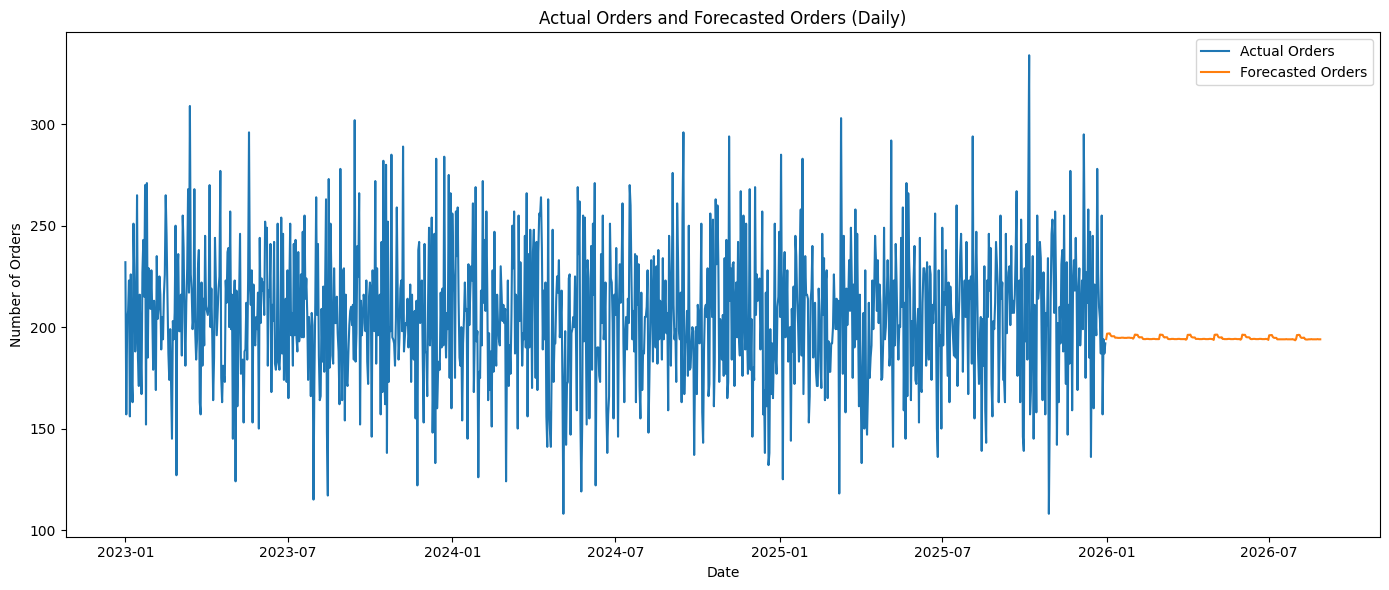

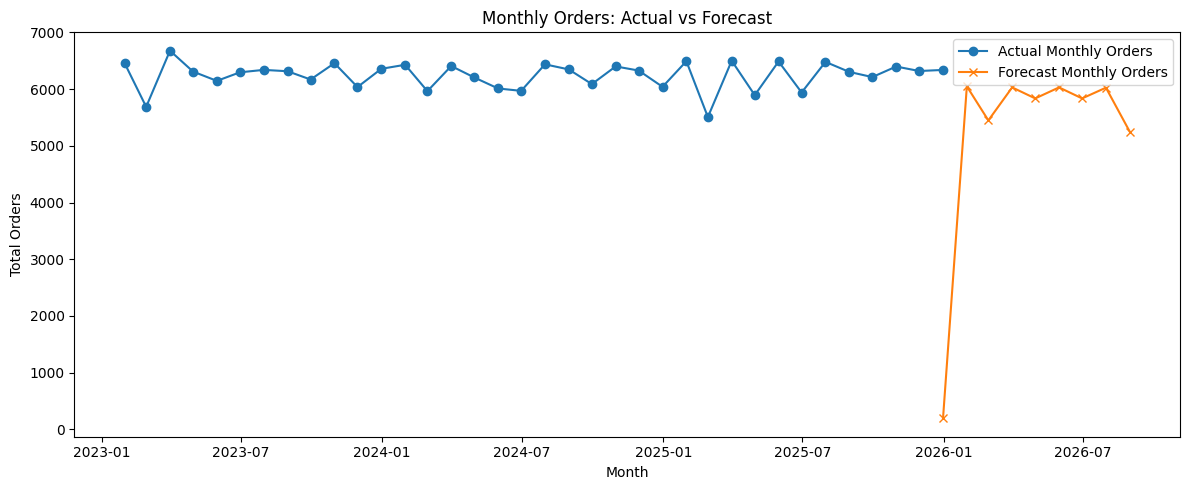

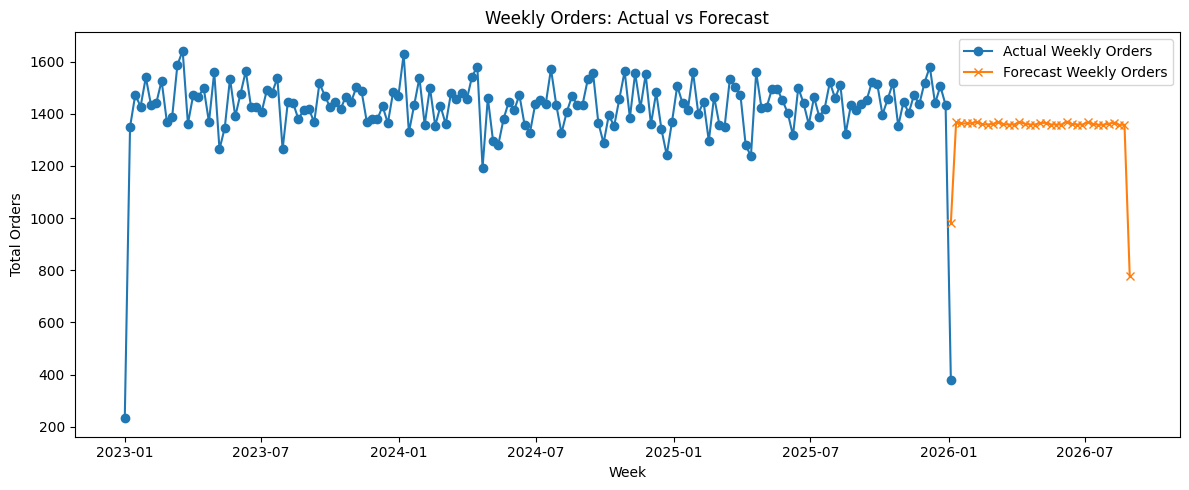


8-Month Forecast Summary (last 10 days):
          date  forecast  safety_stock
230 2026-08-18     194.0         232.8
231 2026-08-19     194.0         232.8
232 2026-08-20     194.0         232.8
233 2026-08-21     194.0         232.8
234 2026-08-22     194.0         232.9
235 2026-08-23     194.0         232.9
236 2026-08-24     194.1         232.9
237 2026-08-25     194.0         232.8
238 2026-08-26     194.0         232.8
239 2026-08-27     194.0         232.8

Top 10 Predictive Features:
volume_ratio       0.975829
rolling_std_3      0.003166
rolling_mean_3     0.002683
rolling_std_7      0.002112
lag_1              0.001748
rolling_mean_14    0.001451
lag_2              0.001434
value_ratio        0.001421
lag_7              0.001280
rolling_mean_28    0.001271
dtype: float64


In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Configuration
DATA_PATH = r'C:\Users\RADHA KRISHNA\Downloads\data analysis project\data\blinkit_cleaned_data.csv'

# 1. Advanced Data Preparation
print("Loading and transforming data...")
df = pd.read_csv(DATA_PATH, parse_dates=['order_date'])
daily = df.resample('D', on='order_date').agg({
    'order_id': 'count',
    'order_total': 'mean',
    'quantity': 'sum'
}).rename(columns={
    'order_id': 'orders',
    'order_total': 'avg_order_value',
    'quantity': 'total_items'
})

# 2. Feature Engineering with Multiple Time Horizons
print("Creating advanced features...")
features = []

# Calendar features
features.extend([
    ('day_of_week', daily.index.dayofweek),
    ('is_weekend', daily.index.dayofweek.isin([5,6]).astype(int)),
    ('month', daily.index.month),
    ('day_of_month', daily.index.day)
])

# Lagged features with multiple windows
for lag in [1, 2, 3, 7, 14, 21, 28]:
    features.append((f'lag_{lag}', daily['orders'].shift(lag)))

# Rolling statistics
for window in [3, 7, 14, 28]:
    features.extend([
        (f'rolling_mean_{window}', daily['orders'].rolling(window).mean()),
        (f'rolling_std_{window}', daily['orders'].rolling(window).std())
    ])

# Price sensitivity features
features.extend([
    ('value_ratio', daily['avg_order_value'] / daily['avg_order_value'].median()),
    ('volume_ratio', daily['total_items'] / daily['total_items'].median())
])

# Build feature DataFrame
X = pd.DataFrame(dict(features), index=daily.index)
y = daily['orders']

# Handle missing values
X = X.ffill().bfill()
valid_mask = y.notna()
X, y = X[valid_mask], y[valid_mask]

# 3. Time-Series Cross Validation with Scaling
print("Running advanced validation...")
tscv = TimeSeriesSplit(n_splits=5)
scaler = StandardScaler()
model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

metrics = []
for train_index, test_index in tscv.split(X):
    # Scale features
    X_train = scaler.fit_transform(X.iloc[train_index])
    X_test = scaler.transform(X.iloc[test_index])
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.nanmean(np.abs((y_test - y_pred) / y_test)) * 100
    
    metrics.append({
        'r2': r2_score(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'mape': mape
    })

# 4. Final Model Training
print("Training final model...")
X_scaled = scaler.fit_transform(X)
model.fit(X_scaled, y)

# 5. Evaluation
avg_r2 = np.mean([m['r2'] for m in metrics])
avg_mae = np.mean([m['mae'] for m in metrics])
avg_mape = np.mean([m['mape'] for m in metrics])

print(f"""
Final Model Performance:
- Average R² Score: {avg_r2:.3f}
- Average MAE: {avg_mae:.1f} orders
- Average MAPE: {avg_mape:.1f}%
""")

# 6. Forecasting for 8 months (~240 days)
print("\nGenerating 8-month forecast (~240 days)...")
last_date = X.index[-1]
forecast_days = 240
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days)

future_X = []
for i, date in enumerate(forecast_dates, 1):
    record = {
        'day_of_week': date.dayofweek,
        'is_weekend': int(date.dayofweek in [5,6]),
        'month': date.month,
        'day_of_month': date.day
    }
    
    # Lag features - using last known values of y (actual orders)
    for lag in [1, 2, 3, 7, 14, 21, 28]:
        if len(y) >= lag:
            record[f'lag_{lag}'] = y.iloc[-lag]
        else:
            record[f'lag_{lag}'] = y.mean()
    
    # Rolling stats
    for window in [3, 7, 14, 28]:
        if len(y) >= window:
            record[f'rolling_mean_{window}'] = y.iloc[-window:].mean()
            record[f'rolling_std_{window}'] = y.iloc[-window:].std()
        else:
            record[f'rolling_mean_{window}'] = y.mean()
            record[f'rolling_std_{window}'] = y.std()
    
    # Price/volume ratios - use last known daily median ratios
    record.update({
        'value_ratio': daily['avg_order_value'].iloc[-1] / daily['avg_order_value'].median(),
        'volume_ratio': daily['total_items'].iloc[-1] / daily['total_items'].median()
    })
    
    future_X.append(record)

future_df = pd.DataFrame(future_X, index=forecast_dates)
future_scaled = scaler.transform(future_df)
forecast = model.predict(future_scaled)

# Forecast DataFrame
forecast_result = pd.DataFrame({
    'date': forecast_dates,
    'forecast': forecast.round(1),
    'safety_stock': (forecast * 1.2).round(1)
})

print("\nForecast Preview (last 10 days):")
print(forecast_result.tail(10))

# 7. Actual vs Forecast Analysis and Visualization

# Actual data for comparison
actual_df = daily[['orders']].copy()

# Get overlap dates where actuals exist (for plotting actual vs forecast)
common_dates = actual_df.index.intersection(forecast_result['date'])

combined_df = pd.DataFrame({
    'actual': actual_df.loc[common_dates, 'orders'],
    'forecast': forecast_result.set_index('date').loc[common_dates, 'forecast']
})

# Aggregate monthly sales
monthly_actual = actual_df['orders'].resample('M').sum()
monthly_forecast = forecast_result.set_index('date')['forecast'].resample('M').sum()

# Aggregate weekly sales
weekly_actual = actual_df['orders'].resample('W').sum()
weekly_forecast = forecast_result.set_index('date')['forecast'].resample('W').sum()

# Plot daily actual vs forecast (overlapping period)
plt.figure(figsize=(14,6))
plt.plot(actual_df.index, actual_df['orders'], label='Actual Orders')
plt.plot(forecast_result['date'], forecast_result['forecast'], label='Forecasted Orders')
plt.title('Actual Orders and Forecasted Orders (Daily)')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.tight_layout()
plt.show()
# Plot monthly aggregated sales
plt.figure(figsize=(12,5))
plt.plot(monthly_actual.index, monthly_actual.values, marker='o', label='Actual Monthly Orders')
plt.plot(monthly_forecast.index, monthly_forecast.values, marker='x', label='Forecast Monthly Orders')
plt.title('Monthly Orders: Actual vs Forecast')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.legend()
plt.tight_layout()
plt.show()

# Plot weekly aggregated sales
plt.figure(figsize=(12,5))
plt.plot(weekly_actual.index, weekly_actual.values, marker='o', label='Actual Weekly Orders')
plt.plot(weekly_forecast.index, weekly_forecast.values, marker='x', label='Forecast Weekly Orders')
plt.title('Weekly Orders: Actual vs Forecast')
plt.xlabel('Week')
plt.ylabel('Total Orders')
plt.legend()
plt.tight_layout()
plt.show()

# 8. Business Output - Forecast Table
print("\n8-Month Forecast Summary (last 10 days):")
print(forecast_result.tail(10))

# 9. Feature Importance
print("\nTop 10 Predictive Features:")
importance = pd.Series(model.feature_importances_, index=X.columns)
print(importance.sort_values(ascending=False).head(10))



Model Evaluation Metrics:
R-squared (R²)                : 0.0293
Adjusted R-squared            : -0.0135
Mean Absolute Error (MAE)     : 26.0072
Mean Squared Error (MSE)      : 1108.1483
Root Mean Squared Error (RMSE): 33.2889
Mean Absolute Percentage Error (MAPE): 0.1318
Explained Variance Score      : 0.0293
Max Error                     : 111.3924


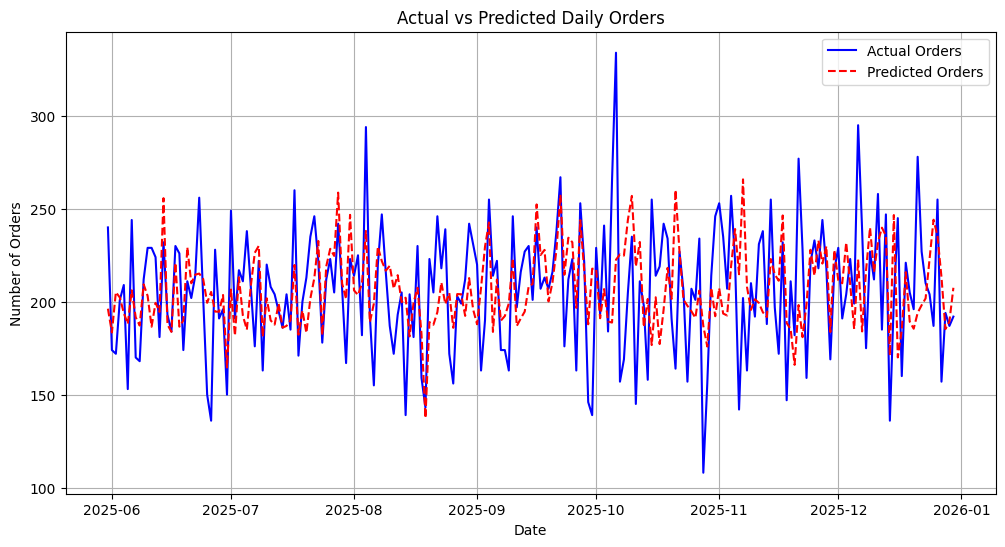


Feature Importance:
        Feature  Importance
 rolling_mean_7    0.259895
          lag_1    0.153909
         lag_14    0.111791
rolling_mean_28    0.107406
rolling_mean_14    0.104445
          lag_7    0.093735
         lag_28    0.088834
          month    0.049727
      dayofweek    0.030259


In [48]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_absolute_error, mean_squared_error, 
                             r2_score, explained_variance_score, 
                             mean_absolute_percentage_error)
import matplotlib.pyplot as plt

def evaluate_sales_forecasting_model(data_path):
    # 1. Load and prepare data
    df = pd.read_csv(data_path)
    df['order_date'] = pd.to_datetime(df['order_date'])
    
    # Create daily aggregates
    daily = df.set_index('order_date').resample('D').agg({
        'order_id': 'count',
        'order_total': 'mean'
    }).rename(columns={
        'order_id': 'actual_orders', 
        'order_total': 'avg_value'
    }).dropna()
    
    # 2. Feature engineering
    def create_features(df):
        features = pd.DataFrame(index=df.index)
        features['dayofweek'] = df.index.dayofweek
        features['month'] = df.index.month
        
        for lag in [1, 7, 14, 28]:
            features[f'lag_{lag}'] = df['actual_orders'].shift(lag)
        
        for window in [7, 14, 28]:
            features[f'rolling_mean_{window}'] = df['actual_orders'].rolling(window).mean()
        
        return features.dropna()
    
    features = create_features(daily)
    X = features
    y = daily['actual_orders'][features.index]
    
    # 3. Train-test split (80-20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # 4. Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 5. Train model
    model = GradientBoostingRegressor(
        n_estimators=200,
        max_depth=5,
        random_state=42
    )
    model.fit(X_train_scaled, y_train)
    
    # 6. Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # 7. Calculate evaluation metrics
    metrics = {
        'R-squared (R²)': r2_score(y_test, y_pred),
        'Adjusted R-squared': 1 - (1 - r2_score(y_test, y_pred)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1),
        'Mean Absolute Error (MAE)': mean_absolute_error(y_test, y_pred),
        'Mean Squared Error (MSE)': mean_squared_error(y_test, y_pred),
        'Root Mean Squared Error (RMSE)': np.sqrt(mean_squared_error(y_test, y_pred)),
        'Mean Absolute Percentage Error (MAPE)': mean_absolute_percentage_error(y_test, y_pred),
        'Explained Variance Score': explained_variance_score(y_test, y_pred),
        'Max Error': max(abs(y_test - y_pred))
    }
    
    # 8. Print metrics
    print("\nModel Evaluation Metrics:")
    print("="*50)
    for metric, value in metrics.items():
        print(f"{metric:30}: {value:.4f}")
    
    # 9. Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Actual Orders', color='blue')
    plt.plot(y_test.index, y_pred, label='Predicted Orders', color='red', linestyle='--')
    plt.title('Actual vs Predicted Daily Orders')
    plt.xlabel('Date')
    plt.ylabel('Number of Orders')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 10. Feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance:")
    print("="*50)
    print(feature_importance.to_string(index=False))
    
    return metrics

# Usage
DATA_PATH = r'C:\Users\RADHA KRISHNA\Downloads\data analysis project\data\blinkit_cleaned_data.csv'
metrics = evaluate_sales_forecasting_model(DATA_PATH)

Loading and preparing data...
Creating features...
Running time-series cross-validation...

Training final model...
Generating 240-day forecast...


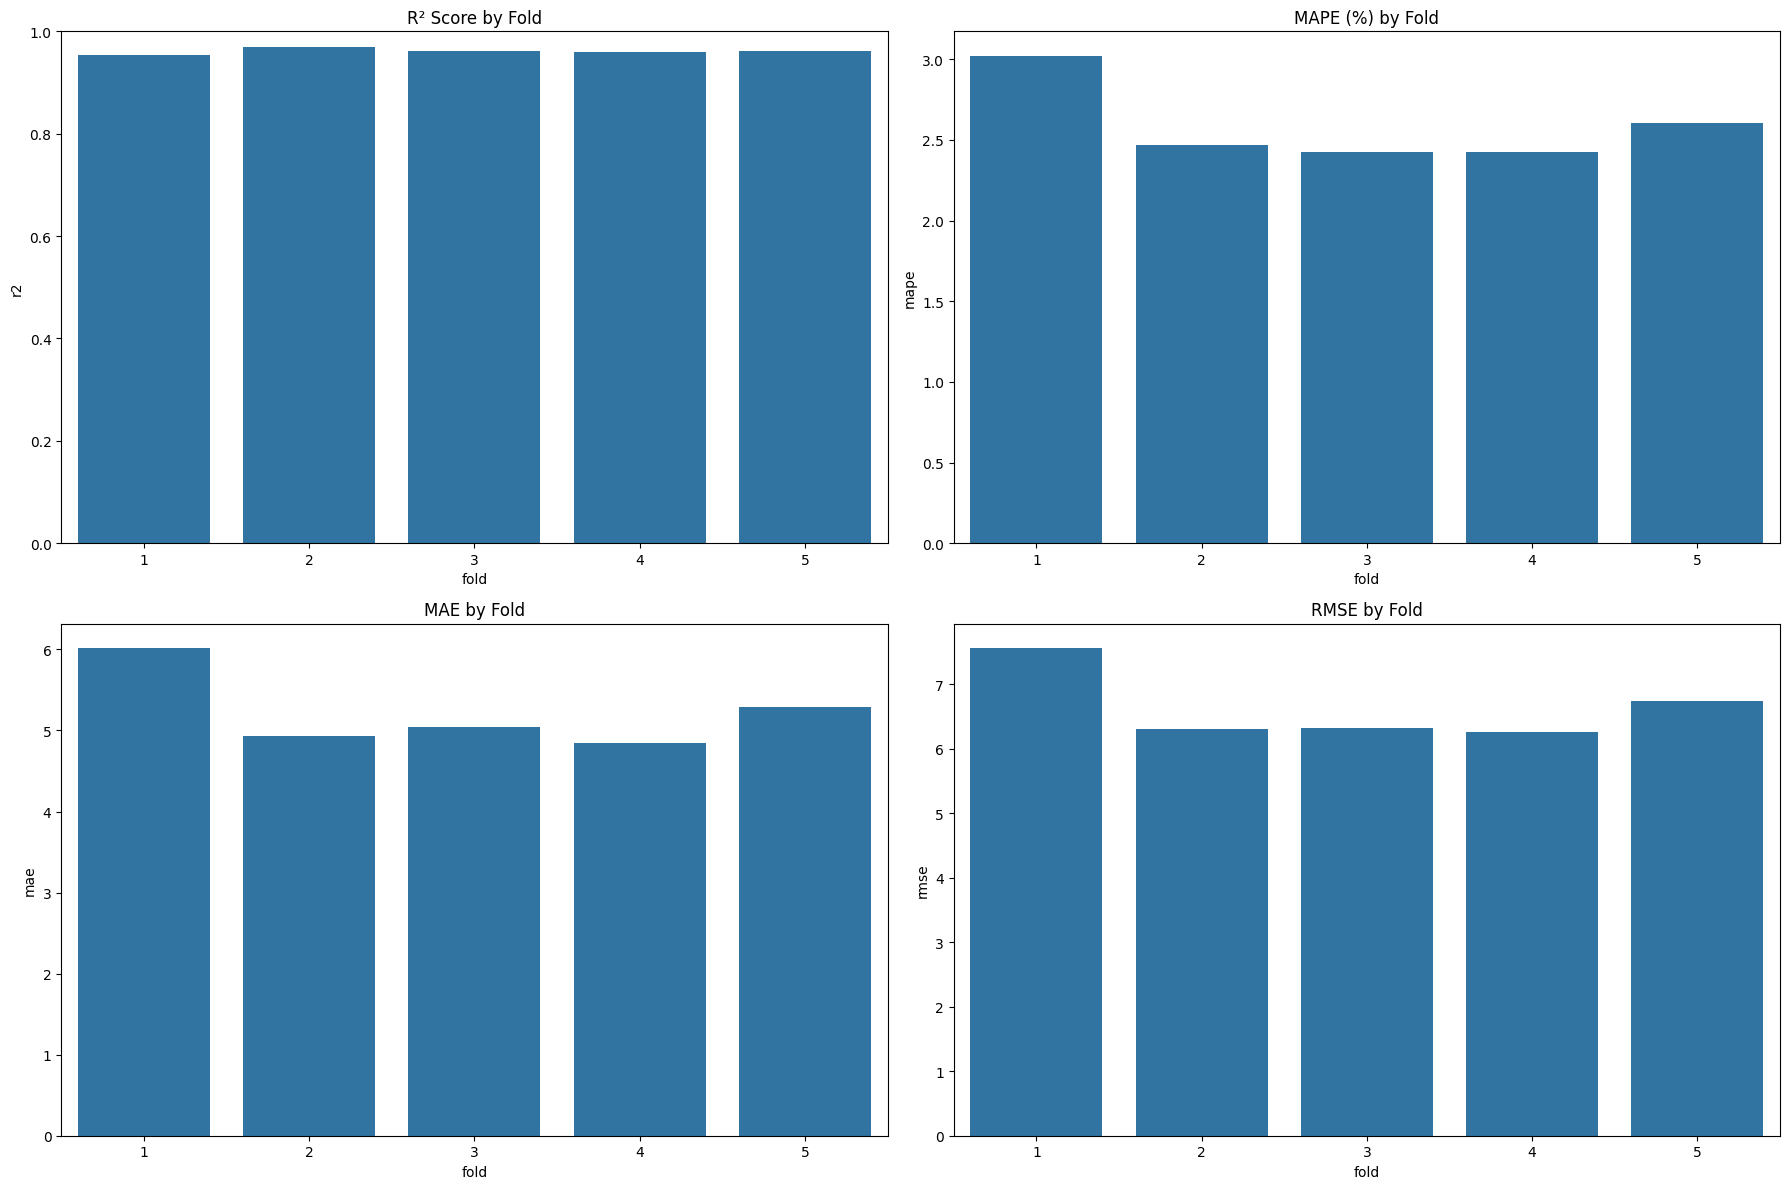

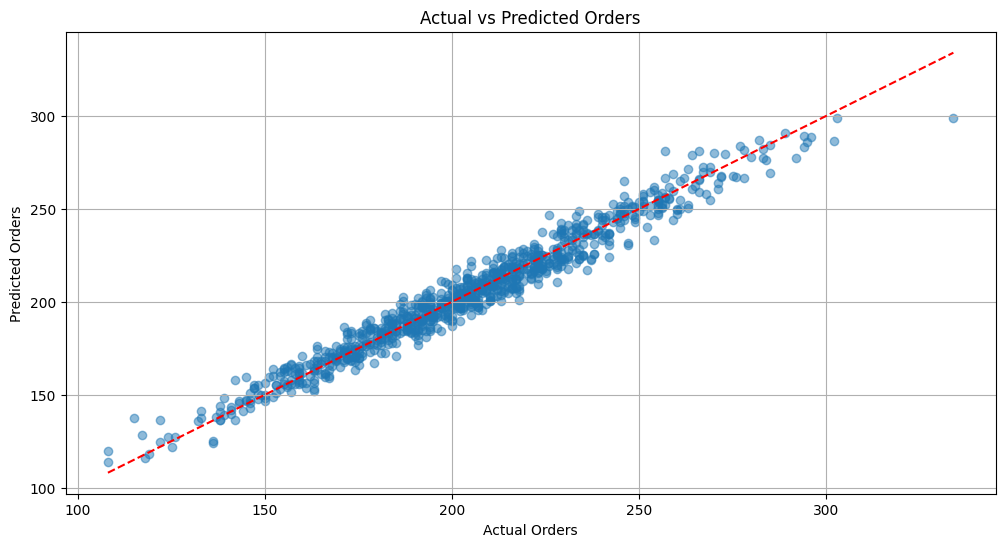

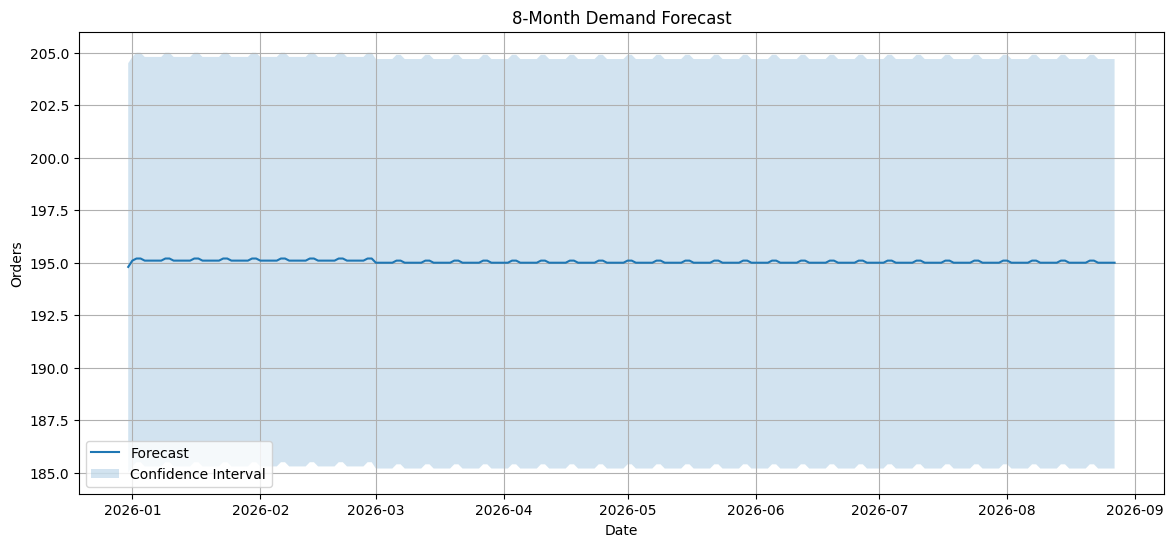


Final Model Metrics:
fold    3.000000
r2      0.961534
mae     5.225972
mape    2.588206
rmse    6.638969
dtype: float64

Forecast and metrics saved successfully!


In [49]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Configuration
DATA_PATH = r'C:\Users\RADHA KRISHNA\Downloads\data analysis project\data\blinkit_cleaned_data.csv'
FORECAST_DAYS = 240  # 8 months
SAFETY_STOCK_RATIO = 1.2

# 1. Load and Prepare Data
print("Loading and preparing data...")
df = pd.read_csv(DATA_PATH, parse_dates=['order_date'])
daily = df.resample('D', on='order_date').agg({
    'order_id': 'count',
    'order_total': 'mean',
    'quantity': 'sum'
}).rename(columns={
    'order_id': 'orders',
    'order_total': 'avg_order_value',
    'quantity': 'total_items'
})

# 2. Feature Engineering
print("Creating features...")
def create_features(df):
    features = pd.DataFrame(index=df.index)
    # Calendar features
    features['day_of_week'] = df.index.dayofweek
    features['is_weekend'] = features['day_of_week'].isin([5,6]).astype(int)
    features['month'] = df.index.month
    
    # Lag features
    for lag in [1, 7, 14, 28]:
        features[f'lag_{lag}'] = df['orders'].shift(lag)
    
    # Rolling statistics
    for window in [7, 14, 28]:
        features[f'rolling_mean_{window}'] = df['orders'].rolling(window).mean()
        features[f'rolling_std_{window}'] = df['orders'].rolling(window).std()
    
    # Original features
    features['avg_order_value'] = df['avg_order_value']
    features['total_items'] = df['total_items']
    
    return features.dropna()

features = create_features(daily)
X = features
y = daily['orders'][features.index]

# 3. Time-Series Cross Validation with Metrics
print("Running time-series cross-validation...")
tscv = TimeSeriesSplit(n_splits=5)
scaler = StandardScaler()
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)

metrics = []
fold_predictions = []

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Scale features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train and predict
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Store predictions
    fold_result = pd.DataFrame({
        'date': X_test.index,
        'actual': y_test,
        'predicted': y_pred
    })
    fold_predictions.append(fold_result)
    
    # Calculate metrics
    metrics.append({
        'fold': fold + 1,
        'r2': r2_score(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'mape': mean_absolute_percentage_error(y_test, y_pred) * 100,
        'rmse': np.sqrt(np.mean((y_test - y_pred)**2))
    })

# 4. Final Model Training
print("\nTraining final model...")
X_scaled = scaler.fit_transform(X)
model.fit(X_scaled, y)

# 5. Generate 8-Month Forecast
print(f"Generating {FORECAST_DAYS}-day forecast...")
last_date = features.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=FORECAST_DAYS)

def create_future_features(target_date):
    feat = {
        'day_of_week': target_date.dayofweek,
        'is_weekend': int(target_date.dayofweek in [5,6]),
        'month': target_date.month,
        'avg_order_value': daily['avg_order_value'].iloc[-1],
        'total_items': daily['total_items'].iloc[-1]
    }
    for lag in [1, 7, 14, 28]:
        feat[f'lag_{lag}'] = y.iloc[-lag] if len(y) >= lag else y.mean()
    for window in [7, 14, 28]:
        feat[f'rolling_mean_{window}'] = y.iloc[-window:].mean() if len(y) >= window else y.mean()
        feat[f'rolling_std_{window}'] = y.iloc[-window:].std() if len(y) >= window else y.std()
    return feat

future_data = [create_future_features(date) for date in forecast_dates]
future_df = pd.DataFrame(future_data, index=forecast_dates)[X.columns]
future_scaled = scaler.transform(future_df)
forecast = model.predict(future_scaled)

# 6. Format Results
forecast_result = pd.DataFrame({
    'date': forecast_dates,
    'forecast': forecast.round(1),
    'safety_stock': (forecast * SAFETY_STOCK_RATIO).round(1),
    'lower_bound': (forecast * 0.95).round(1),
    'upper_bound': (forecast * 1.05).round(1)
})

# 7. Visualization
plt.figure(figsize=(18, 12))

# Metrics Summary
metrics_df = pd.DataFrame(metrics)
plt.subplot(2, 2, 1)
sns.barplot(x='fold', y='r2', data=metrics_df)
plt.title('R² Score by Fold')
plt.ylim(0, 1)

plt.subplot(2, 2, 2)
sns.barplot(x='fold', y='mape', data=metrics_df)
plt.title('MAPE (%) by Fold')

plt.subplot(2, 2, 3)
sns.barplot(x='fold', y='mae', data=metrics_df)
plt.title('MAE by Fold')

plt.subplot(2, 2, 4)
sns.barplot(x='fold', y='rmse', data=metrics_df)
plt.title('RMSE by Fold')

plt.tight_layout()
plt.show()

# Actual vs Predicted
all_predictions = pd.concat(fold_predictions)
plt.figure(figsize=(12, 6))
plt.scatter(all_predictions['actual'], all_predictions['predicted'], alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Orders')
plt.ylabel('Predicted Orders')
plt.title('Actual vs Predicted Orders')
plt.grid()
plt.show()

# Forecast Visualization
plt.figure(figsize=(14, 6))
plt.plot(forecast_result['date'], forecast_result['forecast'], label='Forecast')
plt.fill_between(
    forecast_result['date'],
    forecast_result['lower_bound'],
    forecast_result['upper_bound'],
    alpha=0.2,
    label='Confidence Interval'
)
plt.title('8-Month Demand Forecast')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.legend()
plt.grid()
plt.show()

# 8. Save Results
forecast_result.to_csv('8_month_forecast.csv', index=False)
metrics_df.to_csv('model_metrics.csv', index=False)

print("\nFinal Model Metrics:")
print(metrics_df.mean())

print("\nForecast and metrics saved successfully!")